In [37]:
library(mlr3)
library(mlr3learners)
library(mlr3tuning)
library(mlr3mbo)
library(paradox)
library(xgboost)
library(ranger)
library(data.table)
library(ggplot2)
library(plotly)
library(shiny)
library(shinydashboard)
library(DT)
library(bbotk)
library(microbenchmark)
install.packages("readxl")
library(readxl)
library(repr)
install.packages("corrplot")
library(corrplot)
library(data.table)
library(viridis)
lgr::get_logger("mlr3")$set_threshold("warn")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [38]:
df<- read_excel("/kaggle/input/concrete-dataset/Concrete_Data.xls")

datatable(head(df),options=list(scrollX=TRUE,scrollY="200px",pageLength=5,autoWidth=TRUE))

HTML widgets cannot be represented in plain text (need html)

In [39]:
df <- df %>% 
  rename(
    Cement           = `Cement (component 1)(kg in a m^3 mixture)`,
    Slag             = `Blast Furnace Slag (component 2)(kg in a m^3 mixture)`,
    FlyAsh           = `Fly Ash (component 3)(kg in a m^3 mixture)`,
    Water            = `Water  (component 4)(kg in a m^3 mixture)`,
    Superplasticizer = `Superplasticizer (component 5)(kg in a m^3 mixture)`,
    CoarseAggregate  = `Coarse Aggregate  (component 6)(kg in a m^3 mixture)`,
    FineAggregate    = `Fine Aggregate (component 7)(kg in a m^3 mixture)`,
    Age              = `Age (day)`,
    Strength         = `Concrete compressive strength(MPa, megapascals)`
  )


In [40]:
dim(df)

[1] 1030    9

In [41]:
sum(is.na(df))


[1] 0

In [42]:
colSums(is.na(df))


Cement             Slag           FlyAsh            Water 
               0                0                0                0 
Superplasticizer  CoarseAggregate    FineAggregate              Age 
               0                0                0                0 
        Strength 
               0

In [43]:
str(df)

tibble [1,030 × 9] (S3: tbl_df/tbl/data.frame)
 $ Cement          : num [1:1030] 540 540 332 332 199 ...
 $ Slag            : num [1:1030] 0 0 142 142 132 ...
 $ FlyAsh          : num [1:1030] 0 0 0 0 0 0 0 0 0 0 ...
 $ Water           : num [1:1030] 162 162 228 228 192 228 228 228 228 228 ...
 $ Superplasticizer: num [1:1030] 2.5 2.5 0 0 0 0 0 0 0 0 ...
 $ CoarseAggregate : num [1:1030] 1040 1055 932 932 978 ...
 $ FineAggregate   : num [1:1030] 676 676 594 594 826 ...
 $ Age             : num [1:1030] 28 28 270 365 360 90 365 28 28 28 ...
 $ Strength        : num [1:1030] 80 61.9 40.3 41.1 44.3 ...


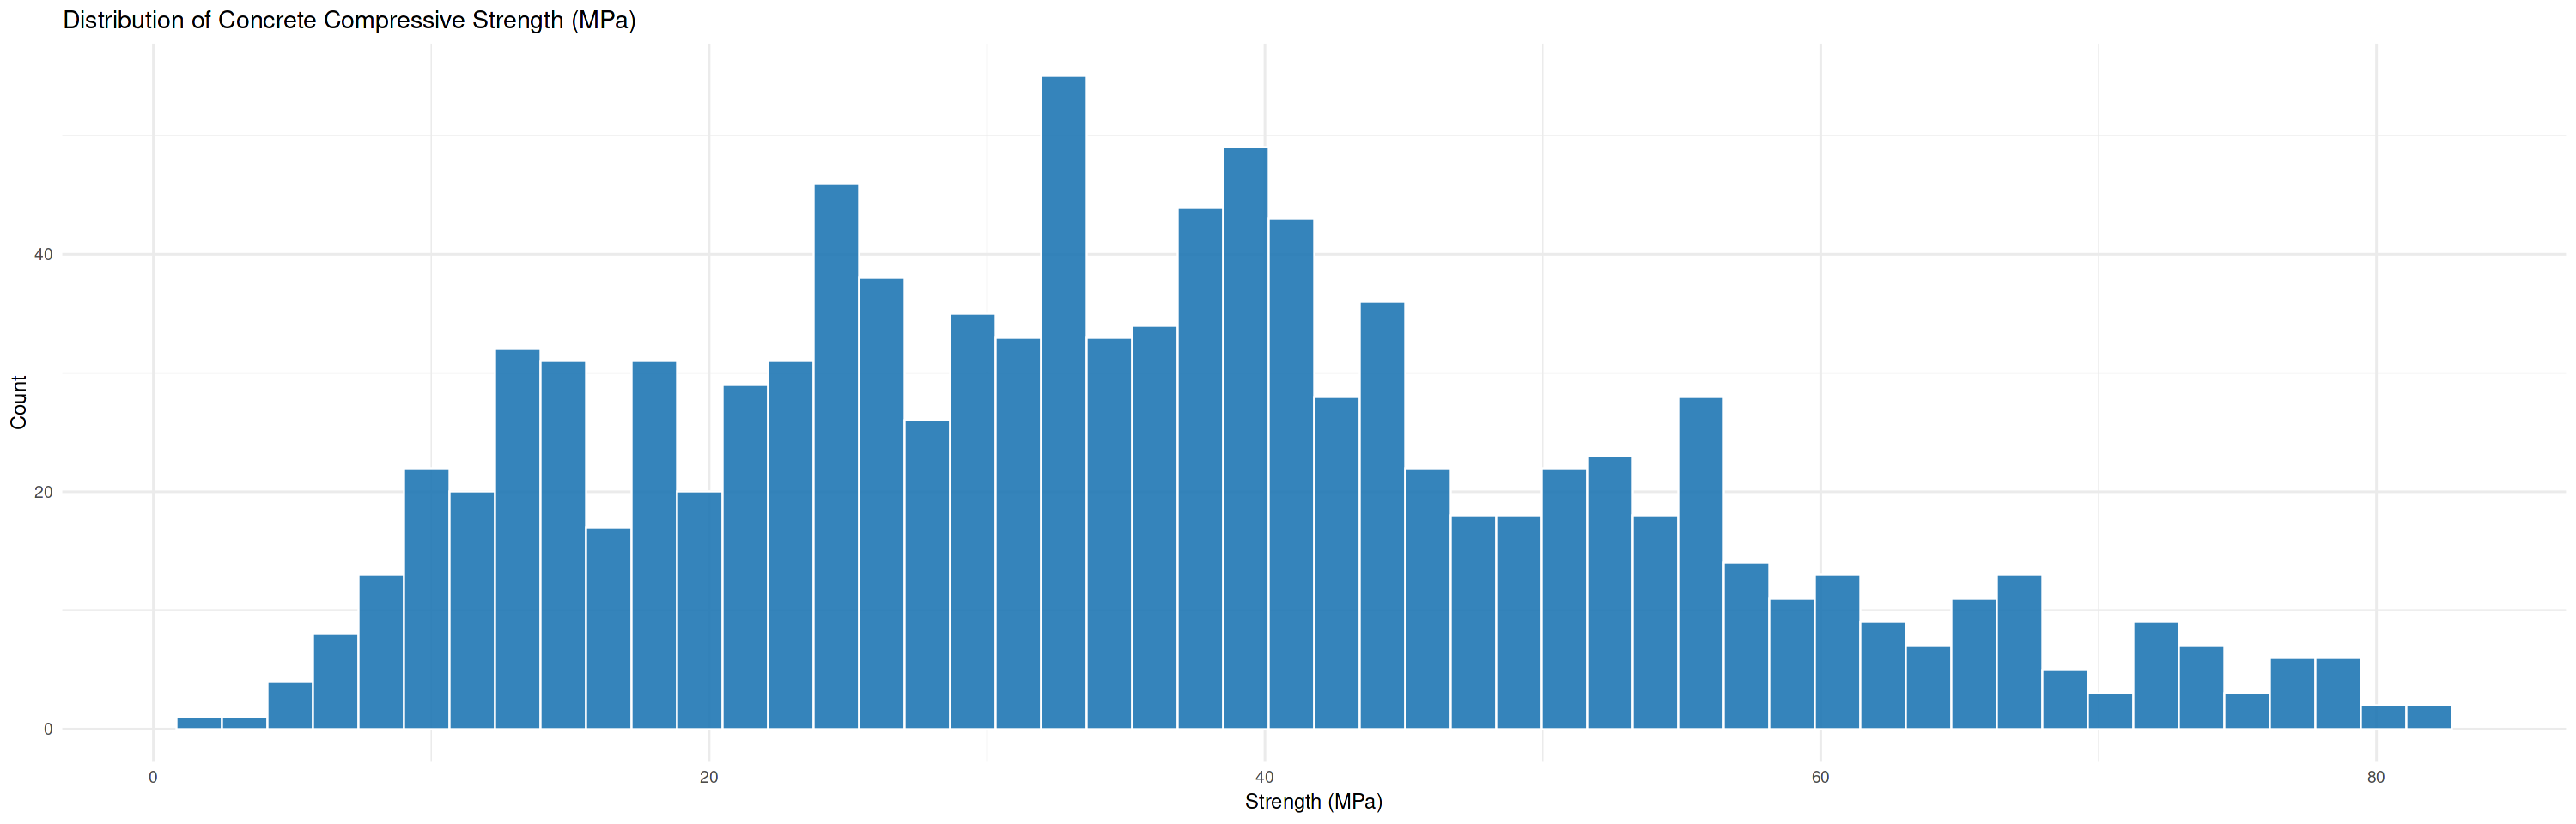

In [44]:
options(repr.plot.width = 25, repr.plot.height = 8)

ggplot(df, aes(x = Strength)) + geom_histogram(bins = 50, fill = "#1f77b4", color = "white", alpha = 0.9) +
  labs(title = "Distribution of Concrete Compressive Strength (MPa)",
       x = "Strength (MPa)", y = "Count") +
  theme_minimal(base_size = 14)

`geom_smooth()` using formula = 'y ~ x'


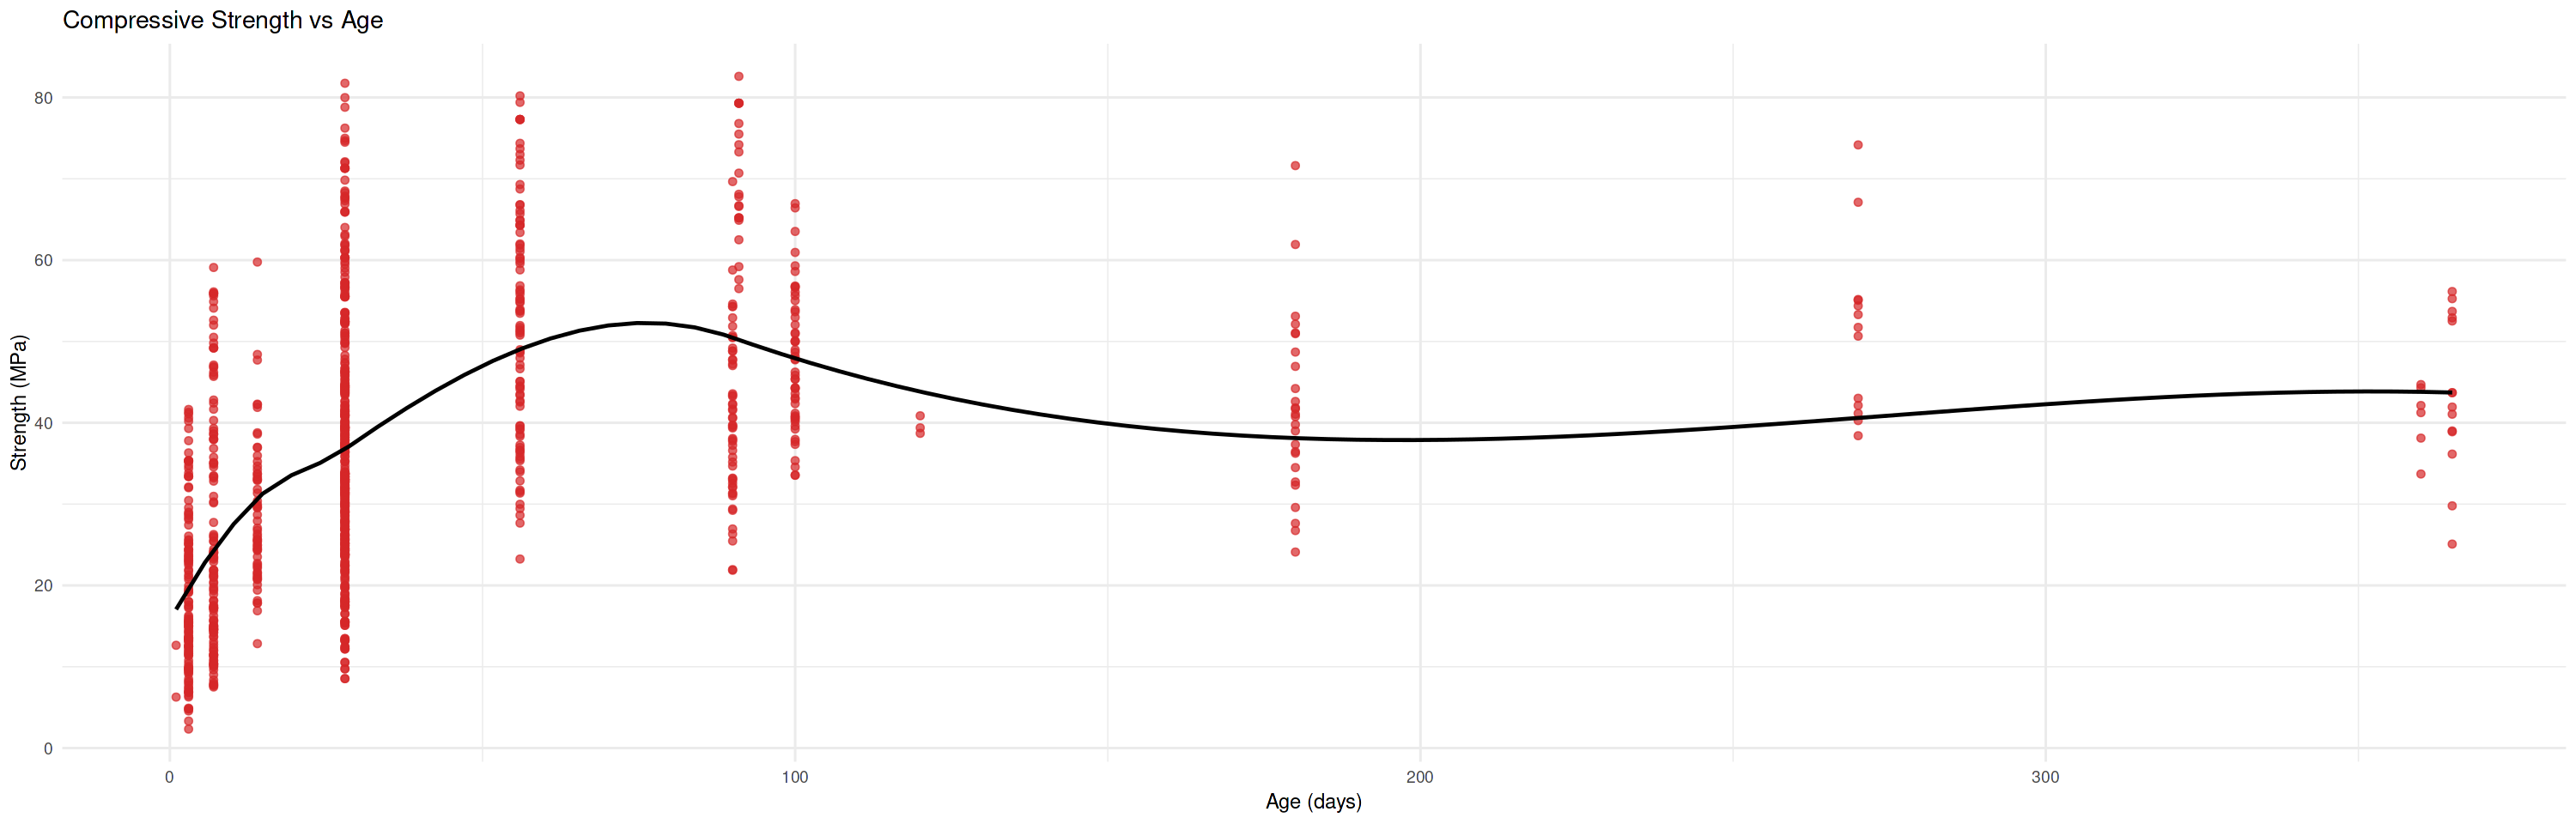

In [45]:
ggplot(df, aes(x = Age, y = Strength)) +
  geom_point(color = "#d62728", alpha = 0.7, size = 2) +
  geom_smooth(method = "loess", color = "black", se = FALSE) +
  labs(title = "Compressive Strength vs Age",
       x = "Age (days)", y = "Strength (MPa)") +
  theme_minimal(base_size = 14)

options(repr.plot.width = 25, repr.plot.height = 8)

`geom_smooth()` using formula = 'y ~ x'


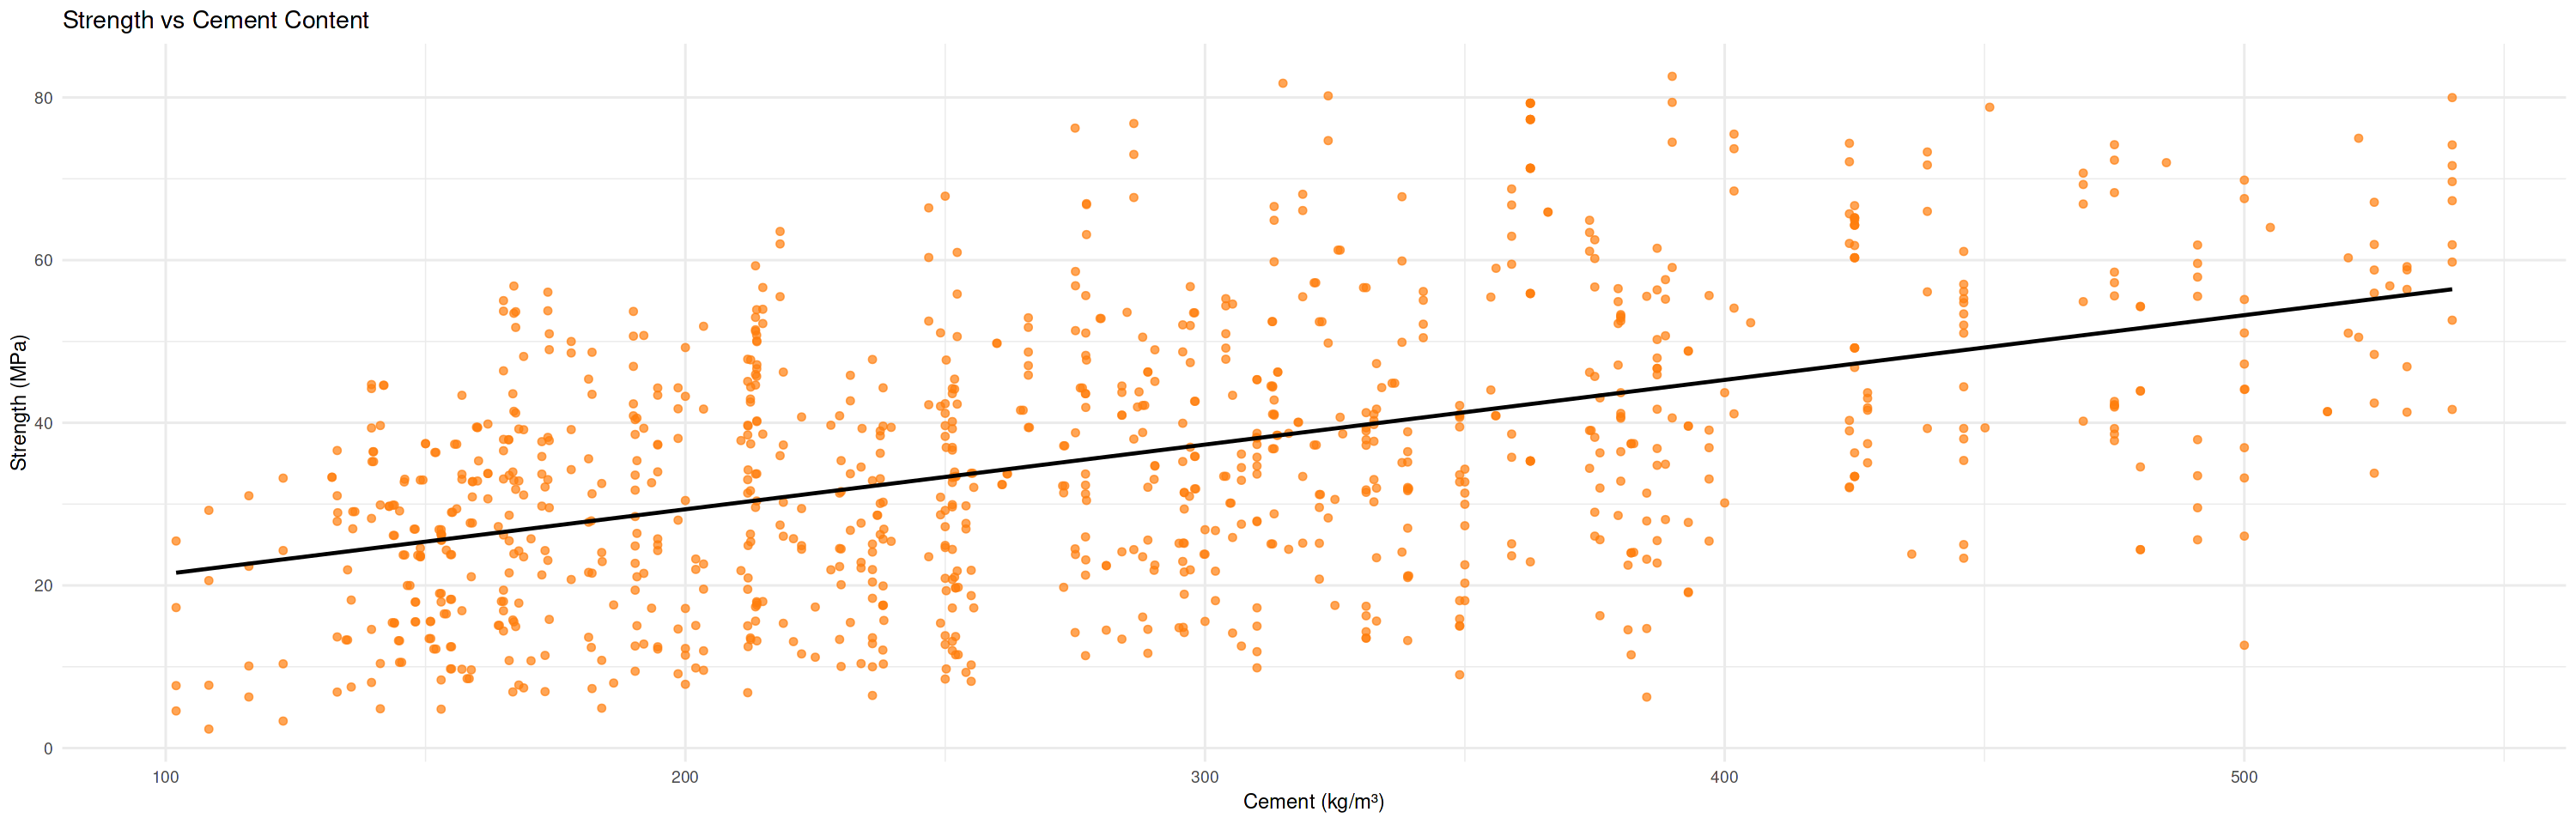

In [46]:
ggplot(df, aes(x = Cement, y = Strength)) +
  geom_point(color = "#ff7f0e", alpha = 0.7, size = 2) +
  geom_smooth(method = "lm", color = "black", se = FALSE) +
  labs(title = "Strength vs Cement Content",
       x = "Cement (kg/m³)", y = "Strength (MPa)") +
  theme_minimal(base_size = 14)

options(repr.plot.width = 25, repr.plot.height = 8)

`geom_smooth()` using formula = 'y ~ x'


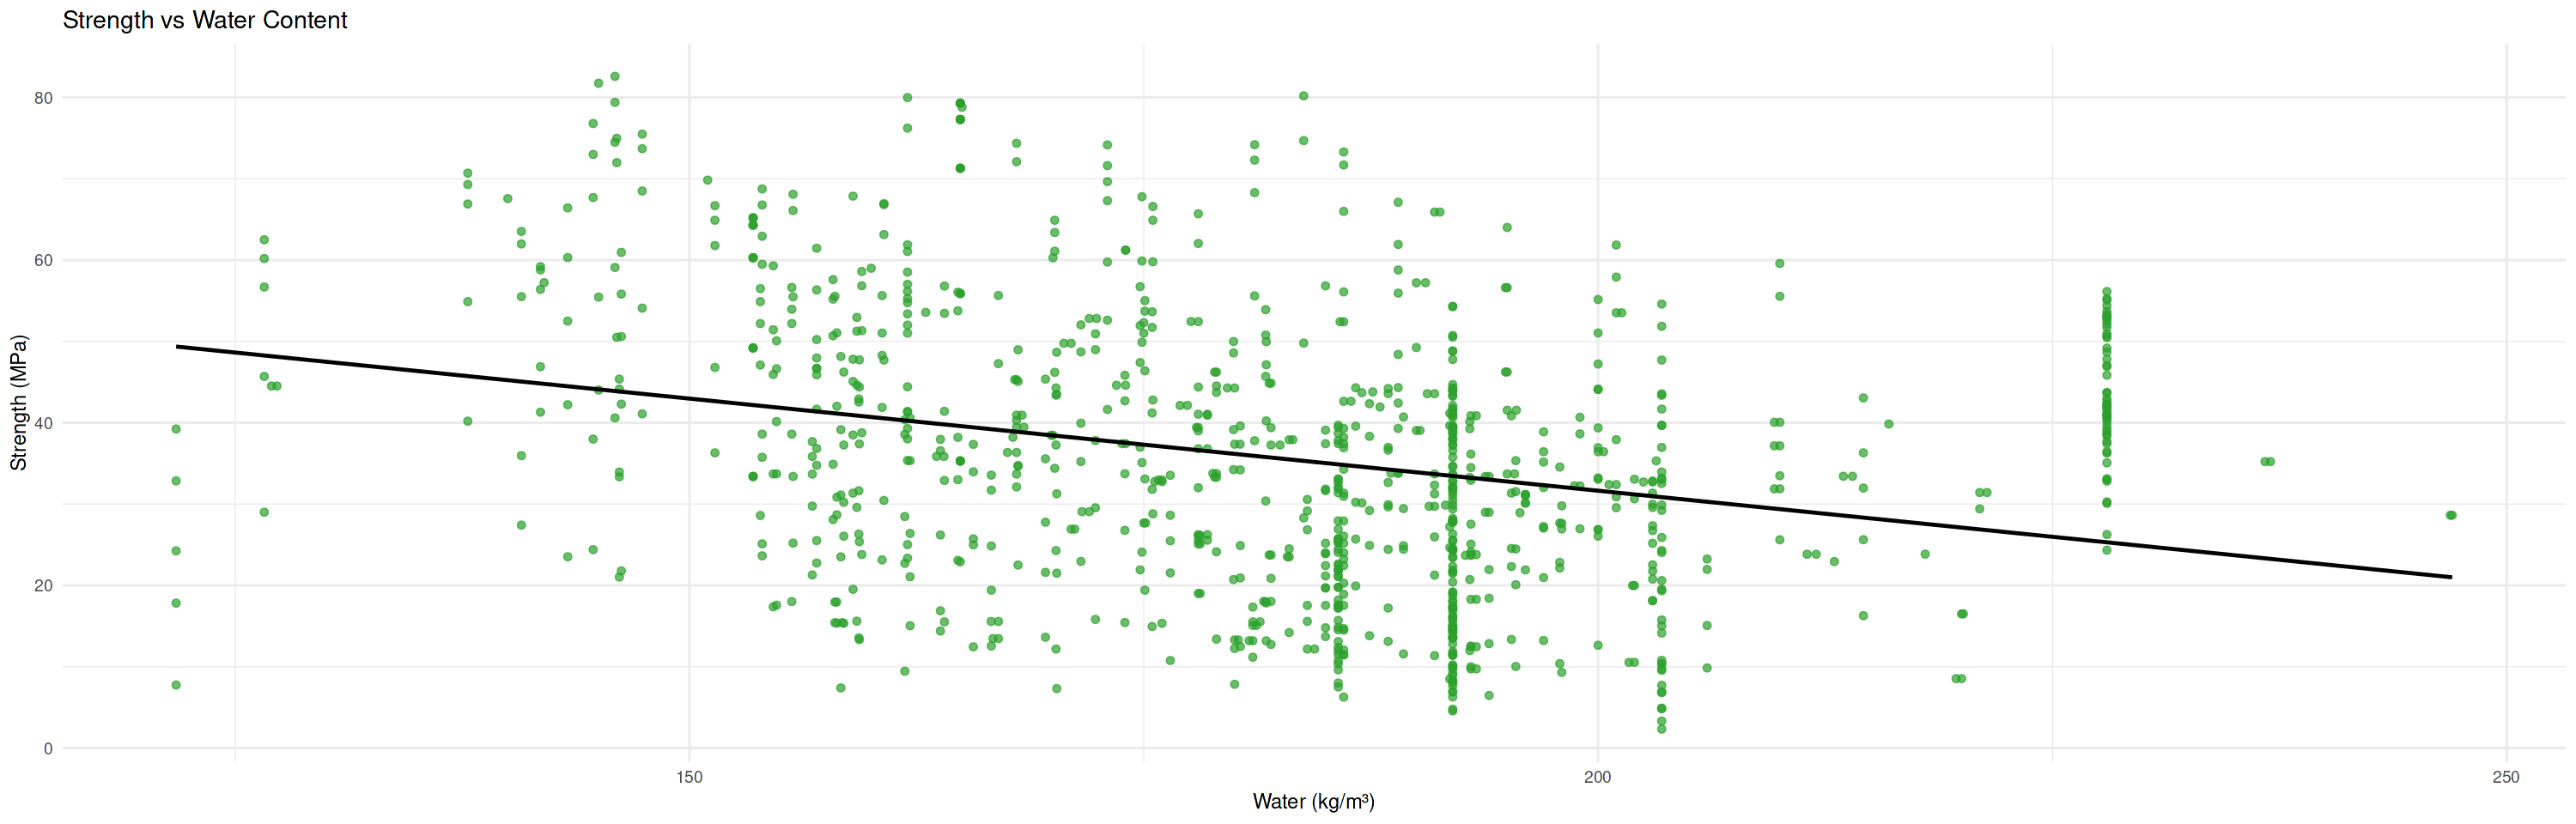

In [47]:
ggplot(df, aes(x = Water, y = Strength)) +
  geom_point(color = "#2ca02c", alpha = 0.7, size = 2) +
  geom_smooth(method = "lm", color = "black", se = FALSE) +
  labs(title = "Strength vs Water Content",
       x = "Water (kg/m³)", y = "Strength (MPa)") +
  theme_minimal(base_size = 14)

options(repr.plot.width = 25, repr.plot.height = 8)

`geom_smooth()` using formula = 'y ~ x'


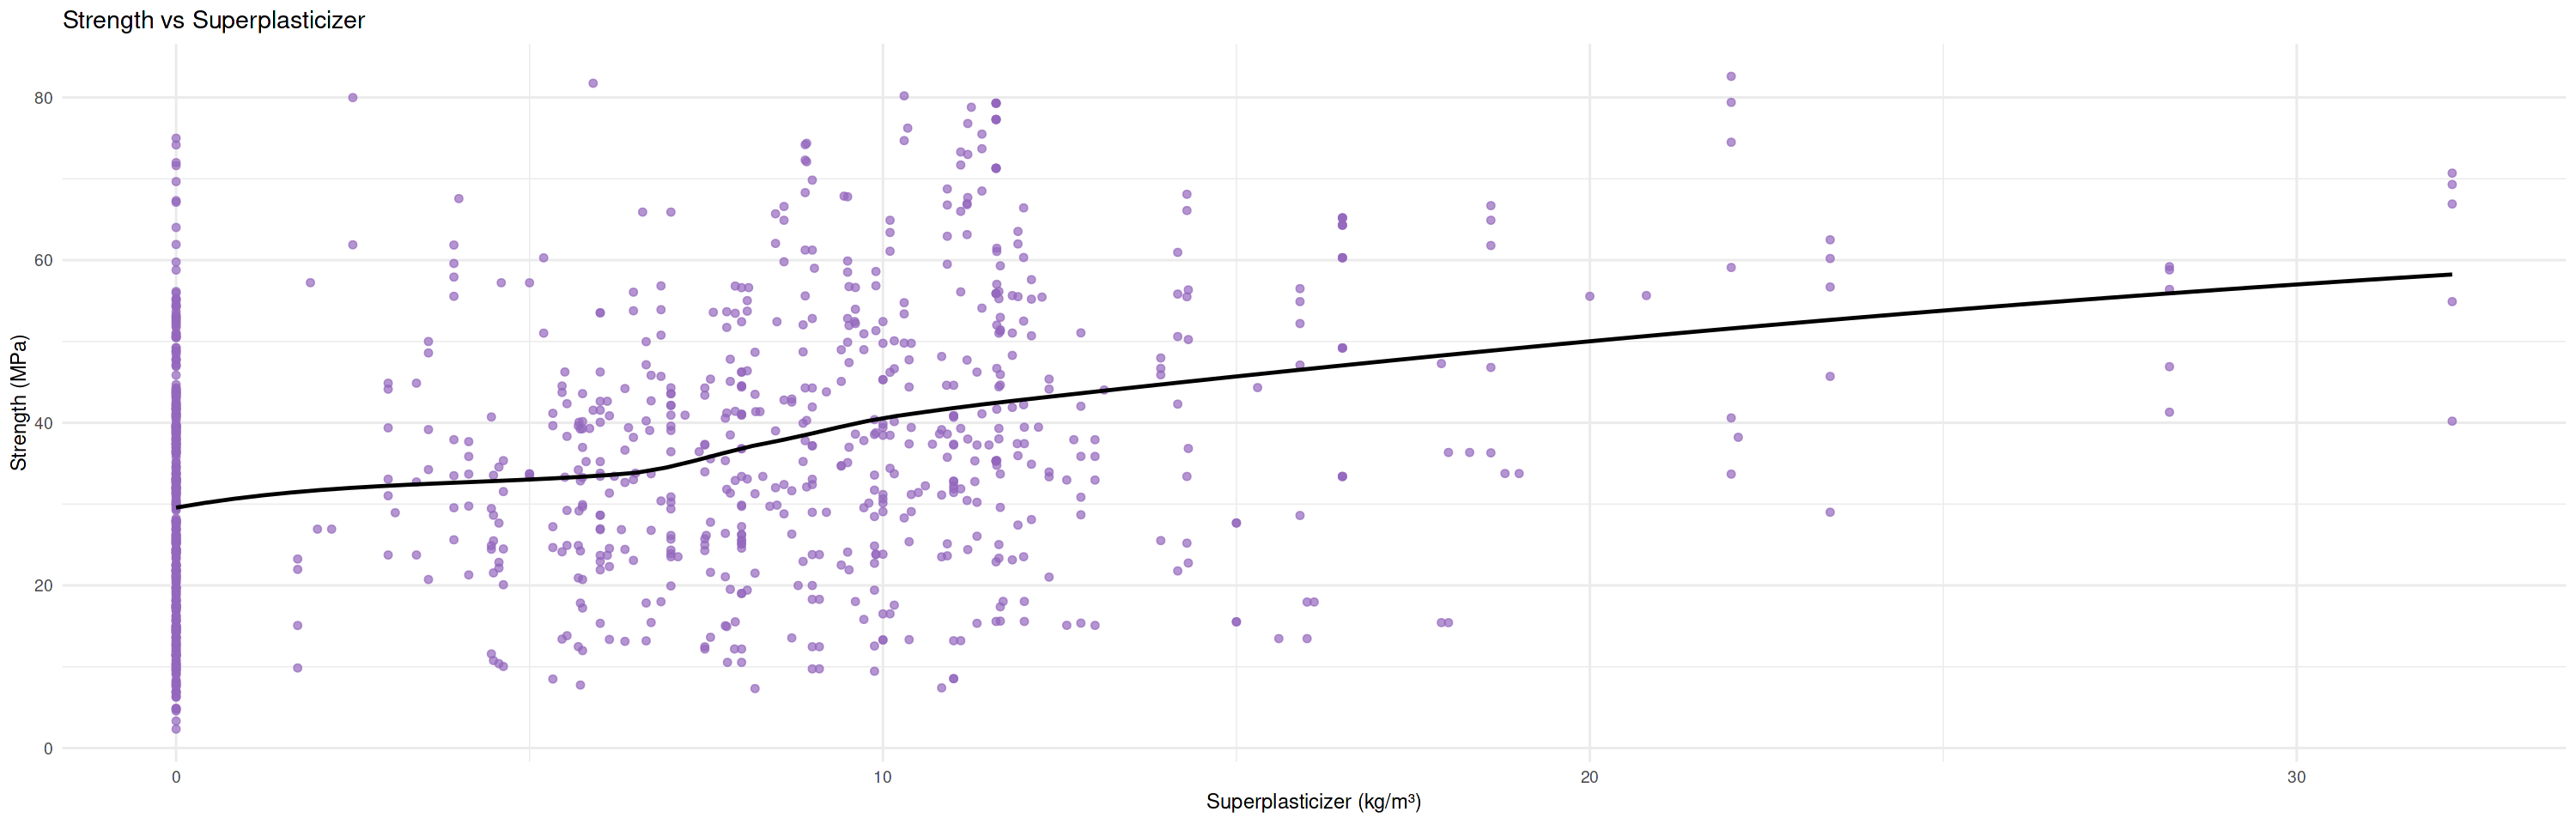

In [48]:
ggplot(df, aes(x = Superplasticizer, y = Strength)) +
  geom_point(color = "#9467bd", alpha = 0.7, size = 2) +
  geom_smooth(method = "loess", color = "black", se = FALSE) +
  labs(title = "Strength vs Superplasticizer",
       x = "Superplasticizer (kg/m³)", y = "Strength (MPa)") +
  theme_minimal(base_size = 14)

options(repr.plot.width = 25, repr.plot.height = 8)

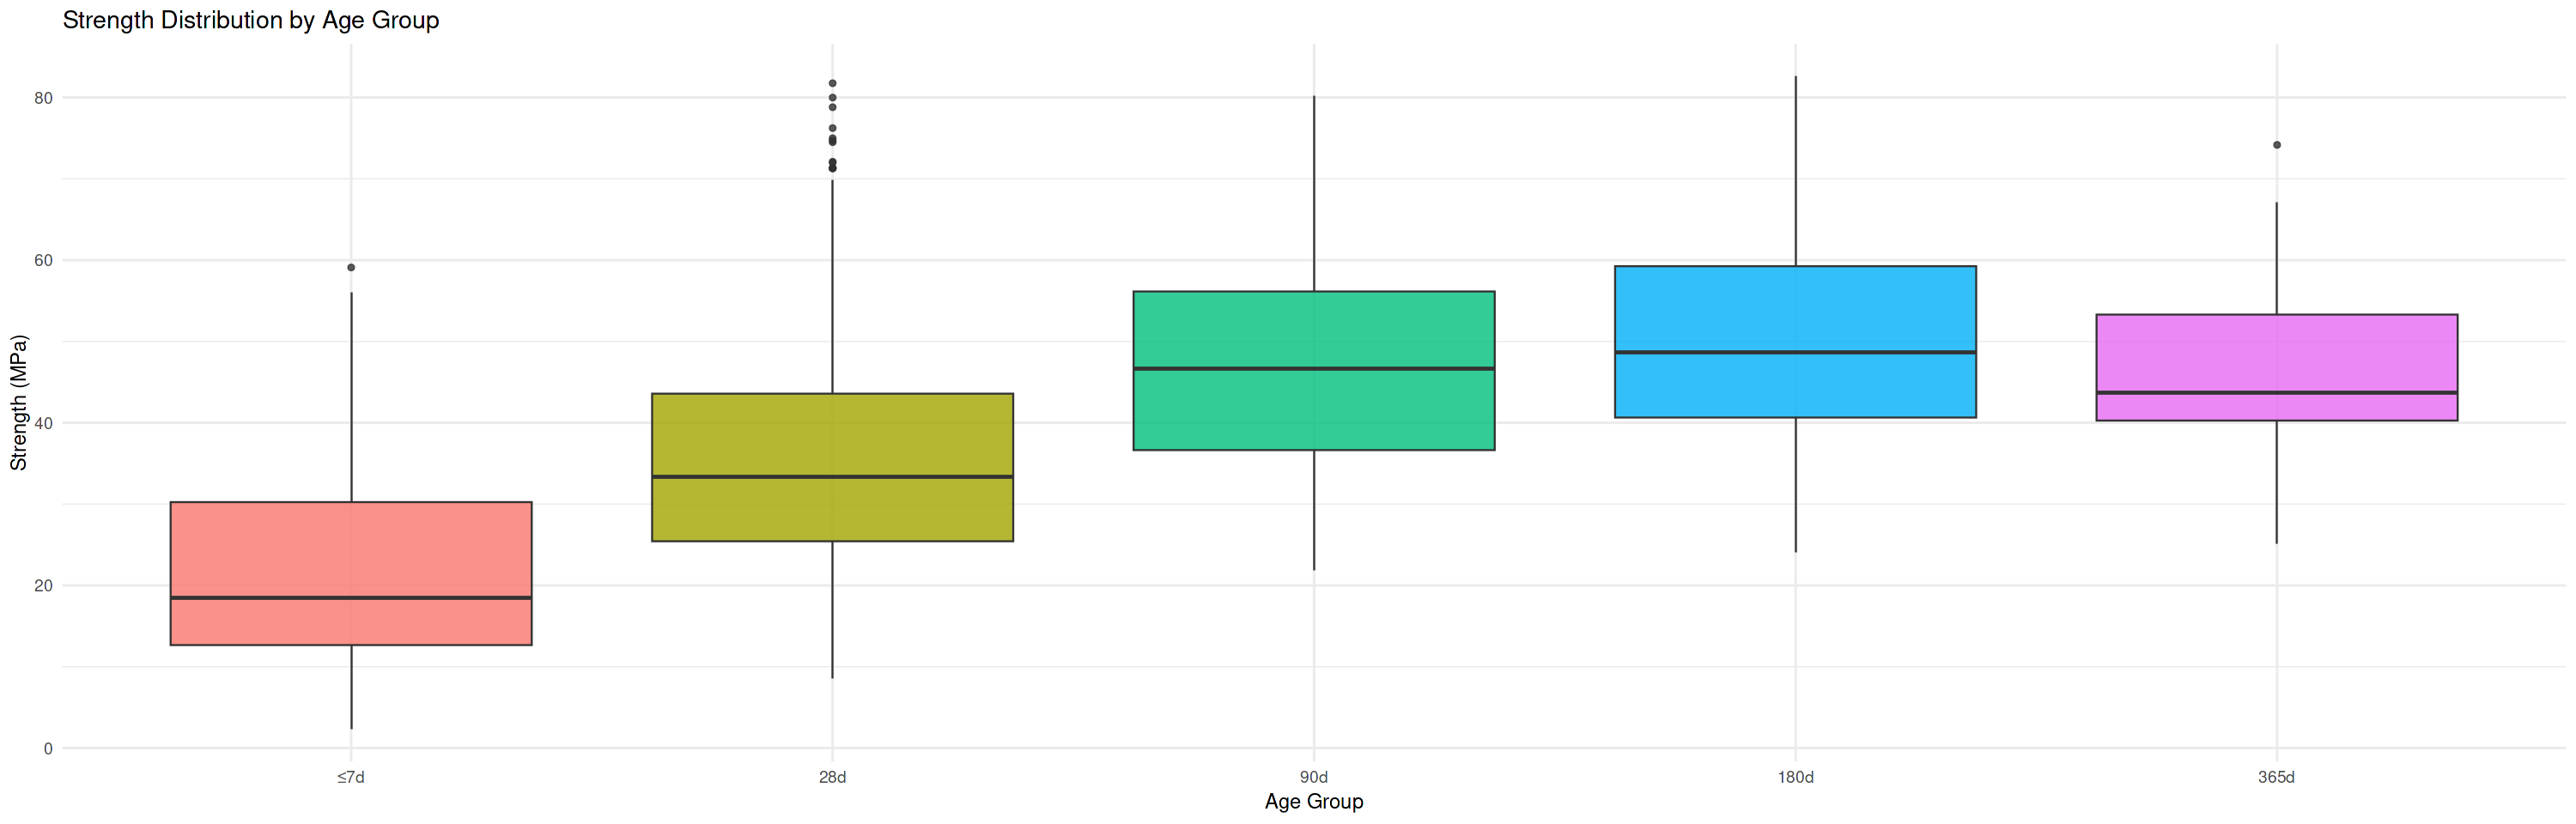

In [49]:
setDT(df)

df[, AgeGroup := cut(
  Age,
  breaks = c(0, 7, 28, 90, 180, 365),
  labels = c("≤7d", "28d", "90d", "180d", "365d")
)]


df[, AgeGroup := cut(Age, breaks = c(0, 7, 28, 90, 180, 365), 
                          labels = c("≤7d", "28d", "90d", "180d", "365d"))]

ggplot(df, aes(x = AgeGroup, y = Strength, fill = AgeGroup)) +
  geom_boxplot(alpha = 0.8) +
  labs(title = "Strength Distribution by Age Group",
       x = "Age Group", y = "Strength (MPa)") +
  theme_minimal(base_size = 14) +
  theme(legend.position = "none")

options(repr.plot.width = 25, repr.plot.height = 8)

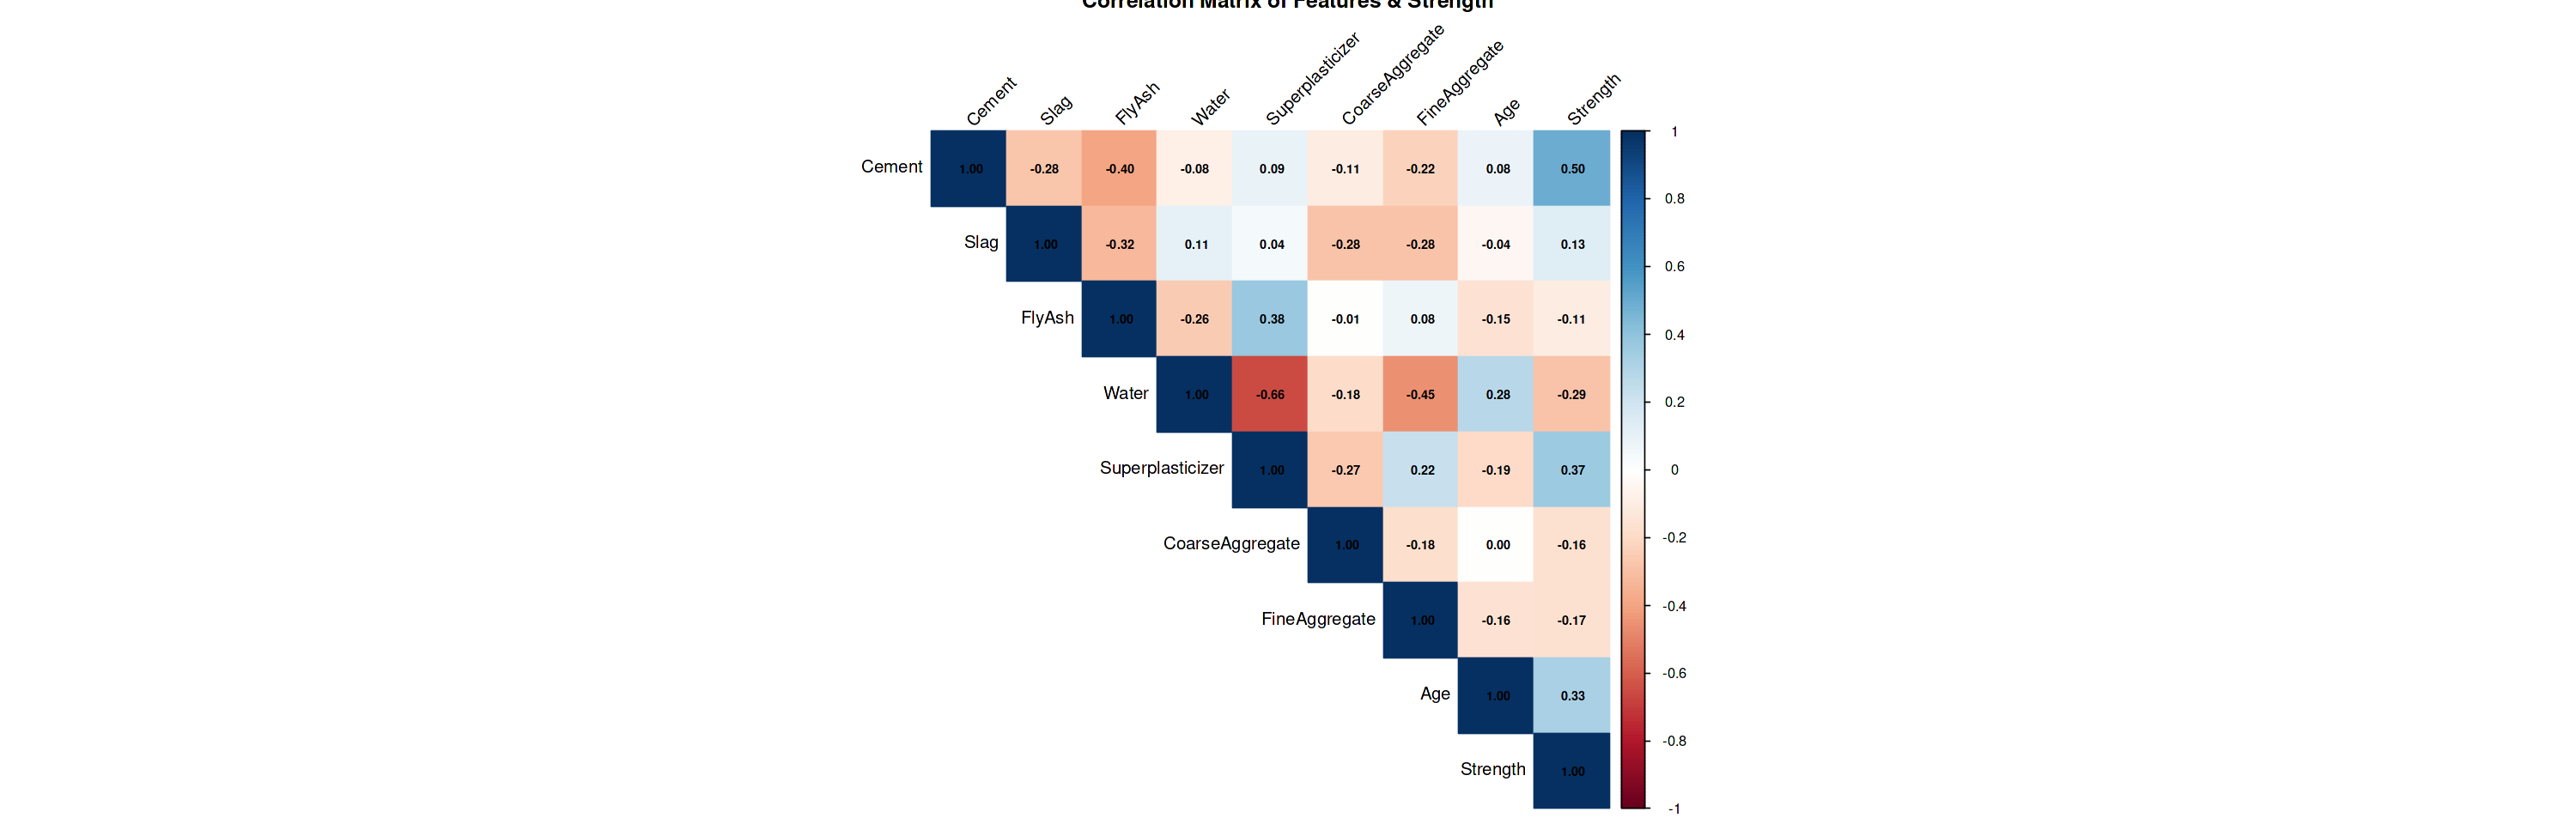

In [50]:
cor_mat <- cor(df %>% dplyr::select(1:9))

corrplot(cor_mat, method = "color", type = "upper",
         tl.col = "black", tl.srt = 45,
         addCoef.col = "black", number.cex = 0.7,
         title = "Correlation Matrix of Features & Strength")

options(repr.plot.width = 25, repr.plot.height = 8)

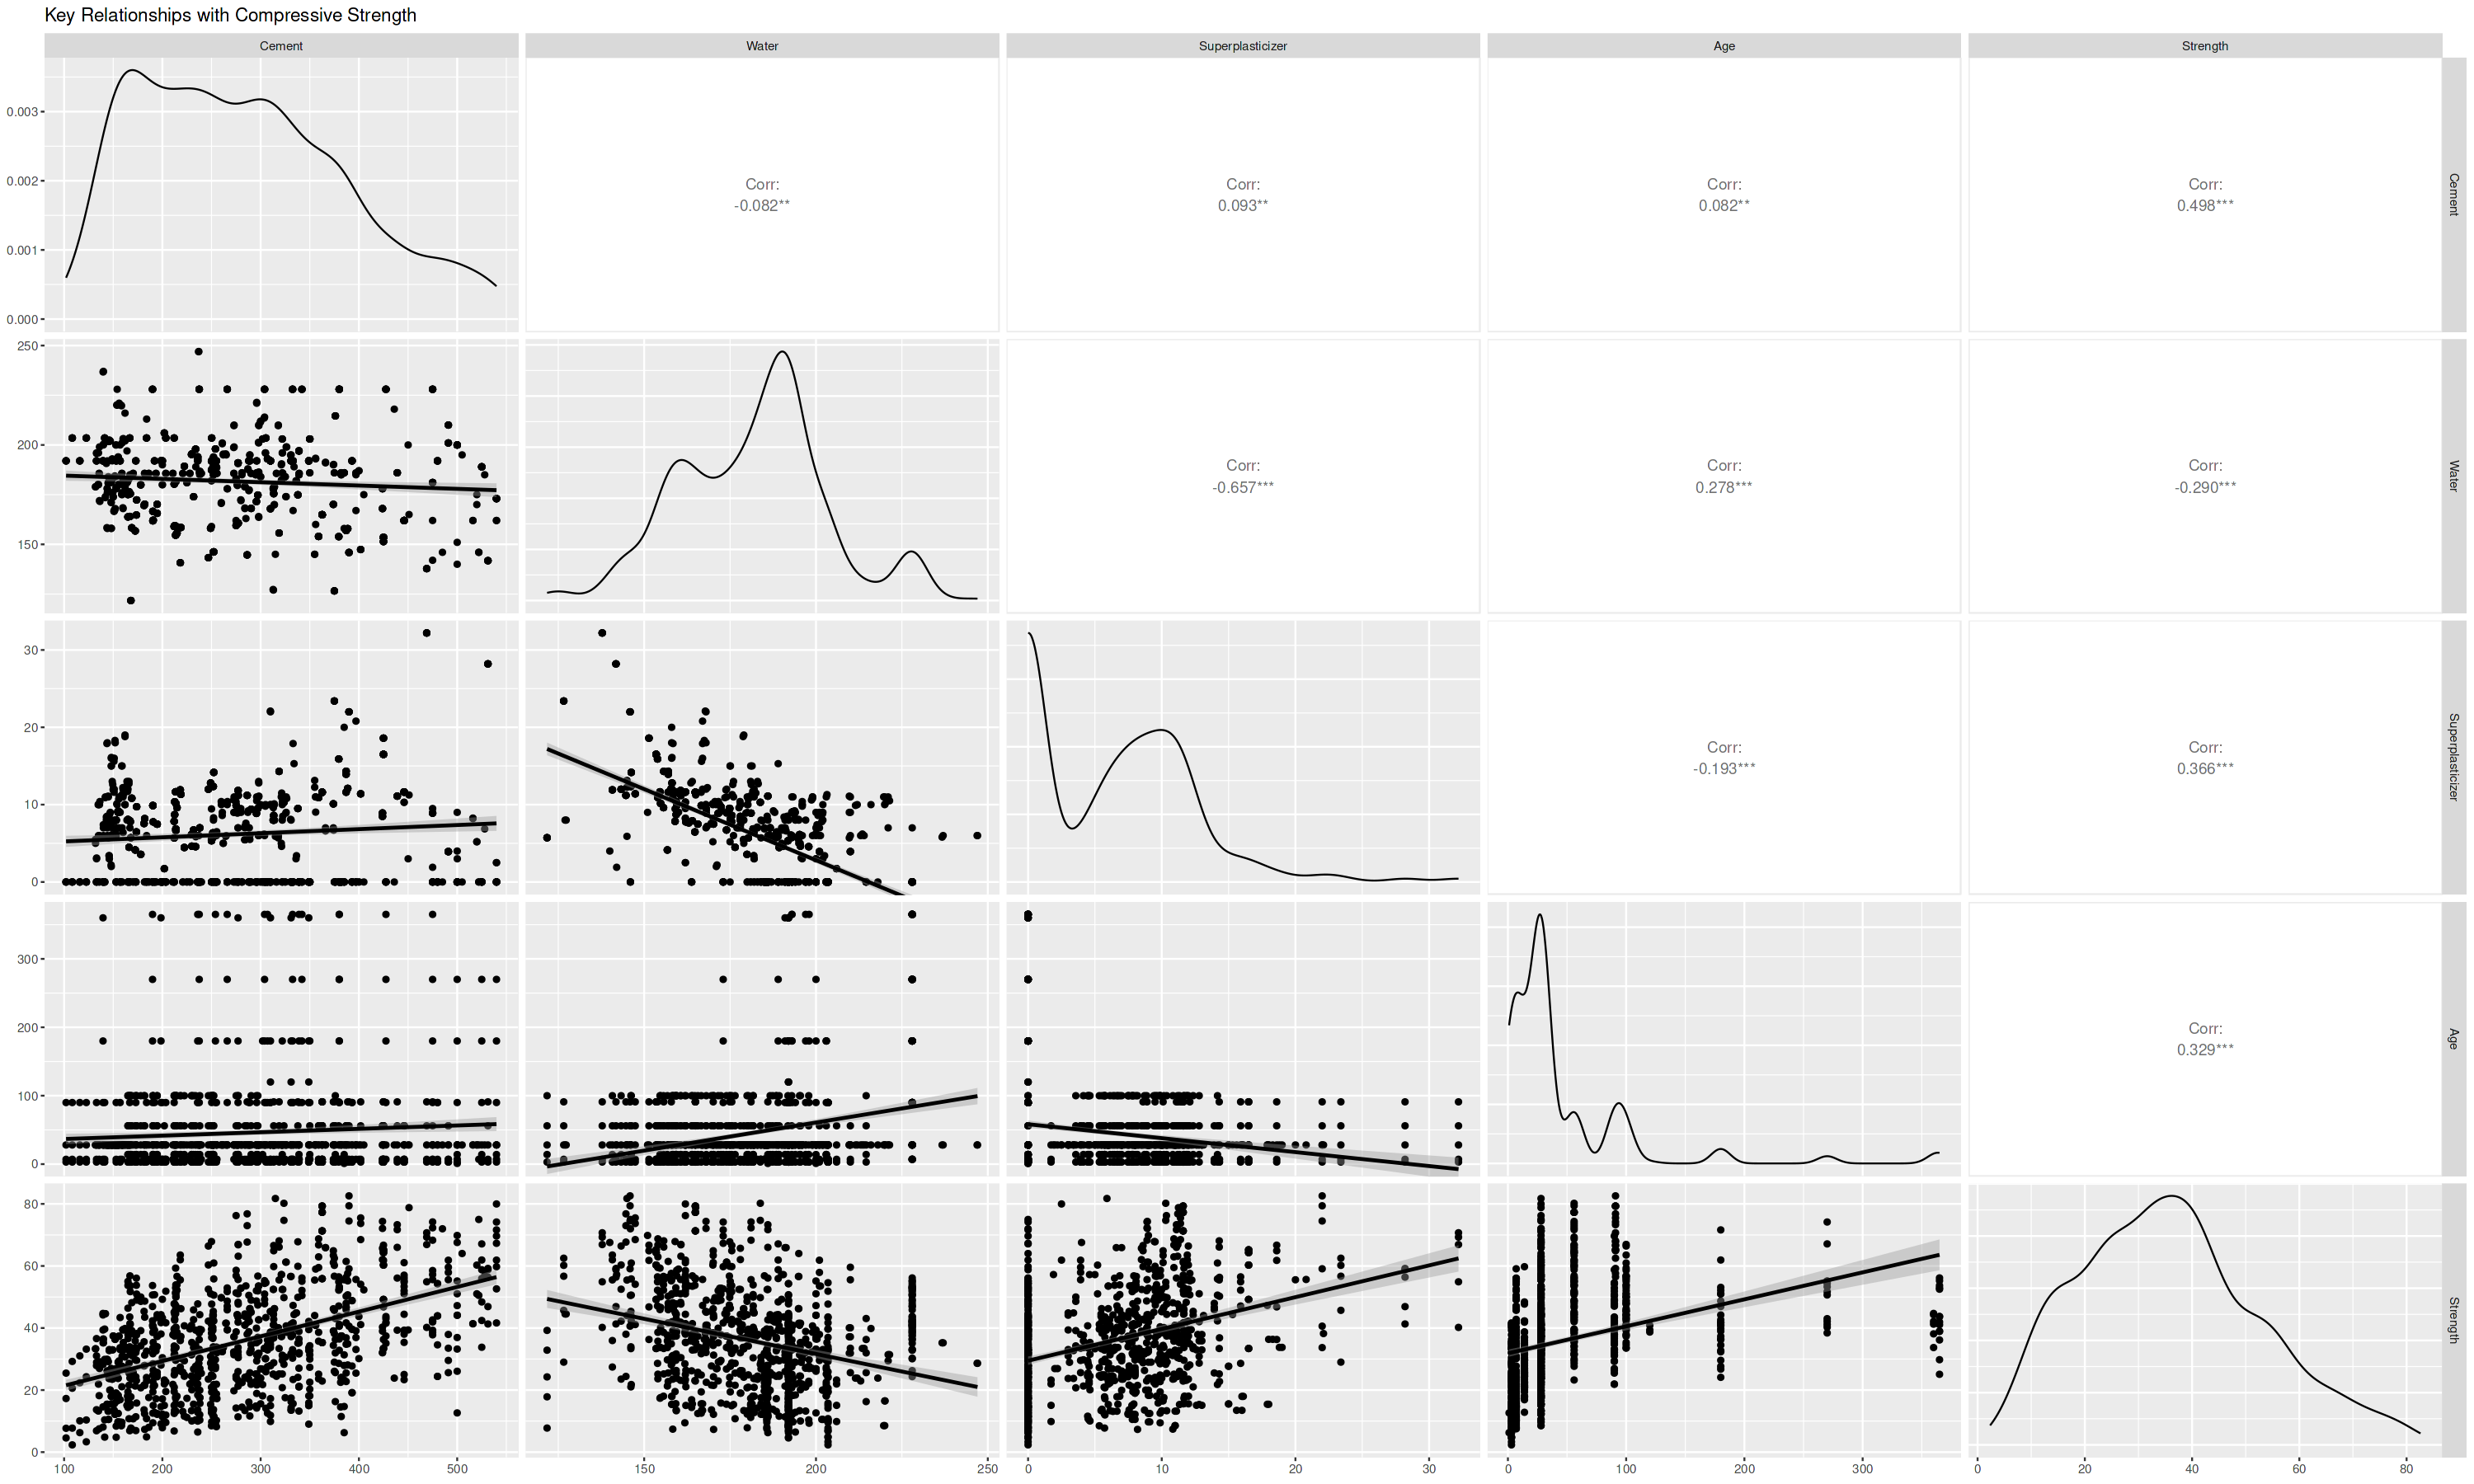

In [51]:
library(GGally)
options(repr.plot.width = 25, repr.plot.height = 15)

ggpairs(df[, .(Cement, Water, Superplasticizer, Age, Strength)],
        title = "Key Relationships with Compressive Strength",
        upper = list(continuous = "cor"),
        lower = list(continuous = "smooth"))



In [52]:
options(repr.plot.width = 25, repr.plot.height = 10)
plot_ly(df, x = ~Cement, y = ~Age, z = ~Strength,
        marker = list(size = 5, color = ~Strength, colorscale = "Viridis", 
                      showscale = TRUE)) %>%
  add_markers() %>%
  layout(title = "3D: Cement × Age → Compressive Strength",
         scene = list(xaxis = list(title = "Cement"),
                      yaxis = list(title = "Age (days)"),
                      zaxis = list(title = "Strength (MPa)")))


HTML widgets cannot be represented in plain text (need html)

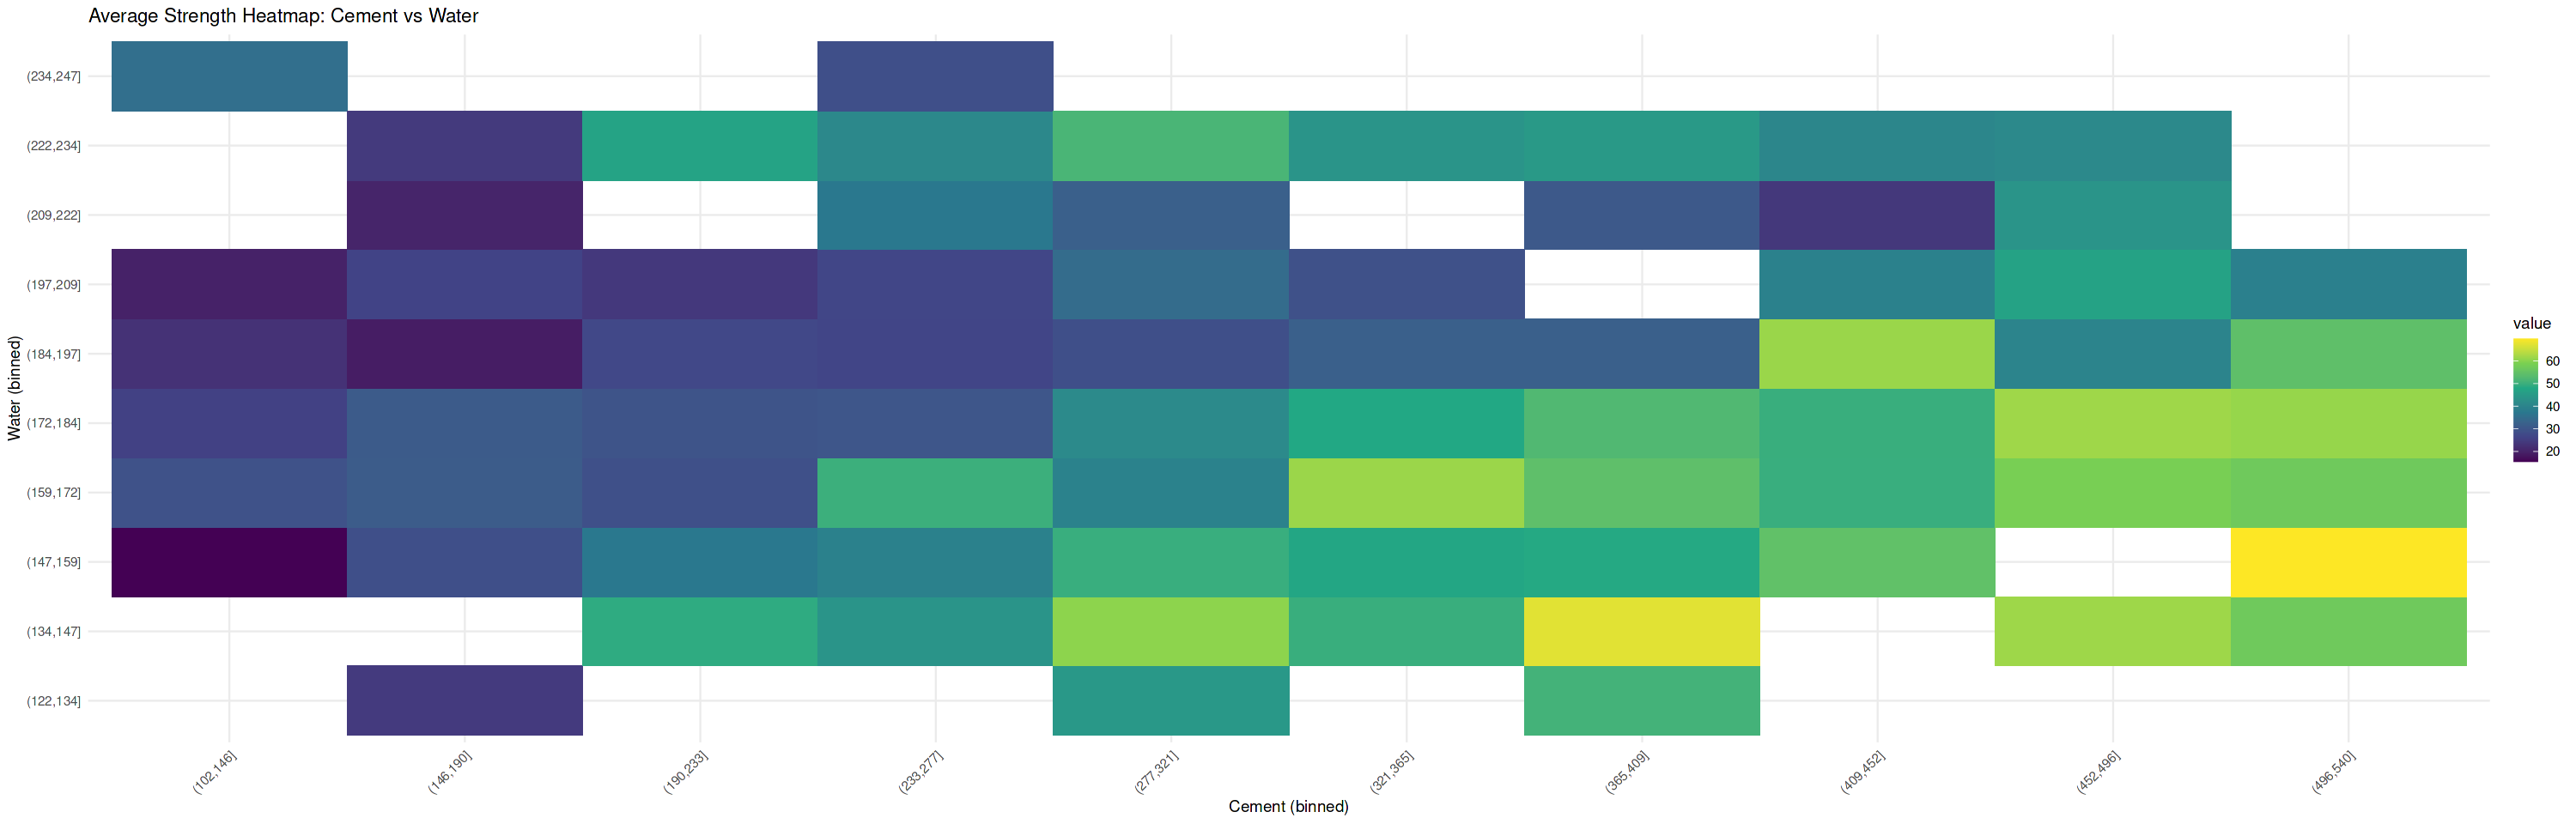

In [53]:
options(repr.plot.width = 25, repr.plot.height = 8)

df[, Cement_bin := cut(Cement, breaks = 10)]
df[, Water_bin := cut(Water, breaks = 10)]

ggplot(df, aes(x = Cement_bin, y = Water_bin, z = Strength, fill = ..value..)) +
  stat_summary_2d(fun = mean, bins = 10) +
  scale_fill_viridis_c() +
  labs(
    title = "Average Strength Heatmap: Cement vs Water",
    x = "Cement (binned)", 
    y = "Water (binned)"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



In [54]:
df[,Age_log:=log(Age+1)]

df <- df %>% select(-AgeGroup, -Cement_bin, -Water_bin, -Age)


df <- df %>%select(Cement, Slag, FlyAsh, Water, Superplasticizer,CoarseAggregate, FineAggregate, Age_log, Strength)

In [55]:

datatable(head(df), options = list(scrollX = TRUE,scrollY="200px", pageLength = 5), rownames = FALSE)

HTML widgets cannot be represented in plain text (need html)

In [56]:
task <- as_task_regr(df[, .(Cement, Slag, FlyAsh, Water, Superplasticizer,CoarseAggregate, FineAggregate, Age_log, Strength)],
                     target = "Strength")
set.seed(42)
train_idx <- sample(seq_len(task$nrow), 800)
test_idx <- setdiff(seq_len(task$nrow), train_idx)

task_train <- task$clone()$filter(train_idx)
task_test <- task$clone()$filter(test_idx)

In [57]:
library(mlr3)
library(mlr3learners)

learner <- lrn("regr.xgboost",
  nrounds          = 500,
  eta              = to_tune(0.01, 0.3),
  max_depth        = to_tune(3, 12),
  subsample        = to_tune(0.6, 1.0),
  colsample_bytree = to_tune(0.6, 1.0),
  min_child_weight = to_tune(1, 10),
  gamma            = to_tune(0, 5),
  booster          = "gbtree"
)

learner$param_set$values$tree_method <- "hist"

In [58]:
obj_fun <- function(xs) {
  lrn_temp <- learner$clone(deep = TRUE)
  
  lrn_temp$param_set$values <- mlr3misc::insert_named(
    lrn_temp$param_set$values,
    xs
  )
  
  lrn_temp$train(task_train)
  
  cv5 <- rsmp("cv", folds = 5)
  rr <- resample(task_train, lrn_temp, cv5)
  rmse <- rr$aggregate(msr("regr.rmse"))
  
  X_test <- task_test$data(cols = task_test$feature_names)
  X_mat <- data.matrix(X_test)
  
  pred_time <- microbenchmark(
    predict(lrn_temp$model, X_mat[1:50, ]),
    times = 1000L,
    unit = "us"
  )
  
  pred_time_value <- summary(pred_time)$median
  
  list(rmse = rmse, pred_time_us = pred_time_value)
}

In [59]:
library(data.table)
library(paradox)
set.seed(42)

search_space <- learner$param_set$search_space()
n_evals <- 100
archive <- data.table()

for (i in 1:n_evals) {
  cfg <- generate_design_random(search_space, n = 1)$data
  xs <- cfg[1, ]
  
  res <- obj_fun(as.list(xs))
  
  row <- c(as.list(xs), list(rmse = res$rmse, pred_time_us = res$pred_time_us, batch_nr = i))
  archive <- rbind(archive, row, fill = TRUE)
  
  cat(sprintf("Eval %3d/%d | RMSE: %.3f | Time: %.1f µs\r", i, n_evals, res$rmse, res$pred_time_us))
}

setorder(archive, rmse, pred_time_us)
archive <- archive[!is.na(rmse) & !is.na(pred_time_us)]

archive[, is_pareto := TRUE]
best_time <- Inf
for (i in seq_len(nrow(archive))) {
  if (archive[i, pred_time_us] >= best_time) {
    archive[i, is_pareto := FALSE]
  } else {
    best_time <- archive[i, pred_time_us]
  }
}

saveRDS(archive, "concrete_pareto_archive.rds")
cat("\n\nOptimization finished!\n")
cat("Evaluations:", nrow(archive), "\n")
cat("Pareto front size:", sum(archive$is_pareto), "\n")
cat("Best RMSE:", round(min(archive$rmse), 3), "\n")
cat("Fastest prediction:", round(min(archive$pred_time_us), 1), "µs\n")

Eval 100/100 | RMSE: 4.685 | Time: 2052.8 µs

Optimization finished!
Evaluations: 100 
Pareto front size: 6 
Best RMSE: 4.242 
Fastest prediction: 1809.7 µs


In [60]:
pareto <- archive[is_pareto == TRUE]
best_idx <- which.min(archive$rmse + archive$pred_time_us / 1000)

final_params <- as.list(archive[best_idx, .SD, .SDcols = search_space$ids()])

final_learner <- lrn("regr.xgboost")

final_learner$param_set$values <- c(final_params, list(
  nrounds = 500, 
  tree_method = "hist", 
  booster = "gbtree"
))
final_learner$train(task_train)

pred_test <- final_learner$predict(task_test)
metrics <- pred_test$score(c(msr("regr.rmse"), msr("regr.rsq"), msr("regr.mae")))
print(metrics)

regr.rmse  regr.rsq  regr.mae 
4.2881572 0.9273874 2.9652160 


`geom_smooth()` using formula = 'y ~ x'


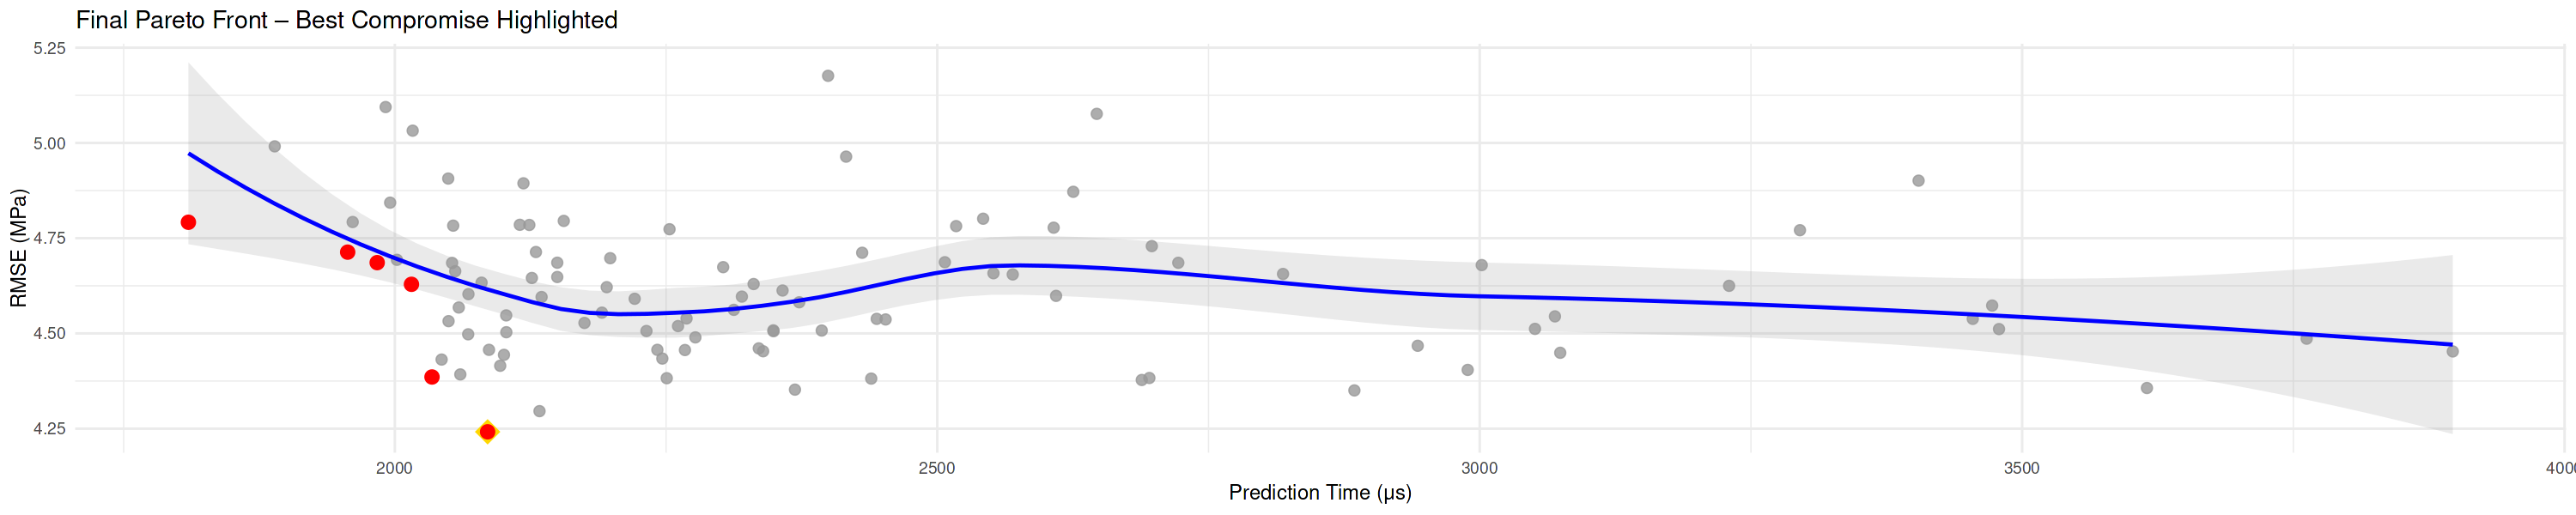

In [62]:
options(repr.plot.width = 25, repr.plot.height = 5)

ggplot(archive, aes(x = pred_time_us, y = rmse)) +
  geom_point(color = "gray60", size = 3, alpha = 0.8) +
  geom_smooth(method = "loess", se = TRUE, color = "blue", alpha = 0.2) +
  geom_point(data = archive[best_idx], color = "gold", size = 8, shape = 18) +
  geom_point(data = pareto, color = "red", size = 4) +
  theme_minimal(base_size = 14) +
  labs(title = "Final Pareto Front – Best Compromise Highlighted",
       x = "Prediction Time (μs)", y = "RMSE (MPa)")